In [1]:
using Revise

In [2]:
using Model
using LogExpFunctions: softmax
using CairoMakie

In [3]:
decisions = Model.loaddata("../../data/processed/json_augmented");

In [18]:
problem = BPatGModel(decisions);

In [65]:
@time post = Model.sample(problem, 2000, 2; backend=:ReverseDiff)

In [64]:
Model.checkconvergence(post)[1]

700-element Vector{Float64}:
  56.51405527547927
  50.8224499526588
  76.79231418842973
 193.5797063273028
  66.45872409955608
 102.88051537647671
  59.60475601474701
  57.73836114040621
  70.25127941119486
 144.34338172706978
   ⋮
 178.35154074168184
 200.0
 196.24344958649692
 200.0
 200.0
 191.8728692251886
 157.92565498827693
  38.43747522279389
  35.871980163212385

In [29]:
function topkgroups(groups, k=10)
    js = reduce(vcat, groups)
    df = DataFrame(groups=js)
    df = combine(groupby(df, :groups), nrow => :count)
    df = sort!(df, :count; rev=true)
    first(df.groups, k)
end

topkgroups (generic function with 2 methods)

In [33]:
function marginaleffects(post, element; group=:judges)
    params = if group == :judges
        (zs=:zj, σs=:σj)
    elseif group == :cpc
        (zs=:zt, σs=:σt)
    else
        throw(ArgumentError("Unknown group."))
    end

    map(post) do s
        zs = getproperty(s, params.zs)
        ze = getindex(zs, element)
        σs = getproperty(s, params.σs)
        αs = s.α
        softmax(vcat(0, αs .+ ze .* σs))
    end
end

marginaleffects (generic function with 1 method)

In [34]:
function plot_marginal_probabilities!(ax, probs)
    for (i, vals) in enumerate(eachcol(hcat(probs...)'))
        m, sd = mean(vals), std(vals)
        errorbars!(ax, [i], [m], [sd]; cycle=:color)
        scatter!(ax, i, m)
    end    
end
function plot_marginal_probabilities(problem, post, groups::Vector{Int}; ncols=4, label="Element")
    fig = Figure()
    for (i, group) in enumerate(groups)
        probs = marginaleffects(post, group)
        pos = fldmod1(i, ncols)
        ax = Axis(fig[pos...]; subtitle = "$label $group")
        plot_marginal_probabilities!(ax, probs)
        hidexdecorations!(ax)
        xlims!(ax, 0.5, 3.5)
        ylims!(ax, 0, 1)
        last(pos) != 1 && (ax.yticksvisible = false; ax.yticklabelsvisible=false)
    end

    colors = Makie.wong_colors()
    lelems = [MarkerElement(color=colors[c], marker=:circle) for c in 1:3]
    Legend(fig[end+1, :], lelems, problem.outcome_labels; nbanks=3)
    
    fig
end

plot_marginal_probabilities (generic function with 1 method)

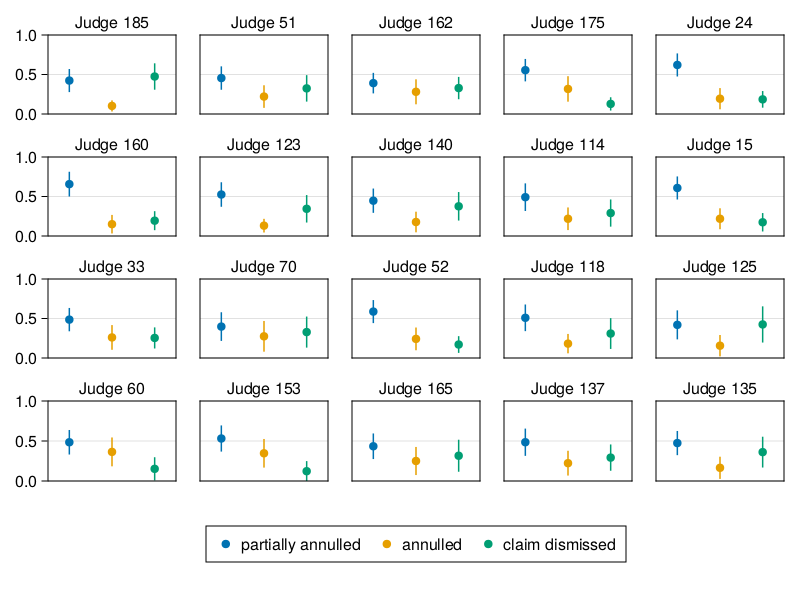

In [35]:
judges = topkgroups(problem.js, 20)
plot_marginal_probabilities(problem, post, judges; label="Judge", ncols=5)

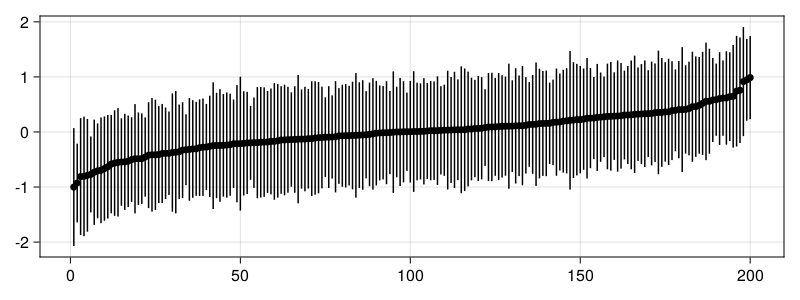

In [49]:
let 
    βs = map(post) do s
        map(last, s.zj)
    end
    means,sds = mean(βs), std(βs)
    idx = sortperm(means)

    fig = Figure(resolution=(800, 300))
    ax = Axis(fig[1,1])
    errorbars!(ax, eachindex(means), means[idx], sds[idx])
    scatter!(ax, eachindex(means), means[idx]; color=:black, markersize=10)
    fig
end

In [36]:
function plot_densities(draws)
    fig = Figure()
    ax1 = Axis(fig[1,1])
    hist!(first.(draws); label="annulled")
    hist!(last.(draws); label="claim dismissed")
    axislegend(ax1)
    fig
end

plot_densities (generic function with 1 method)

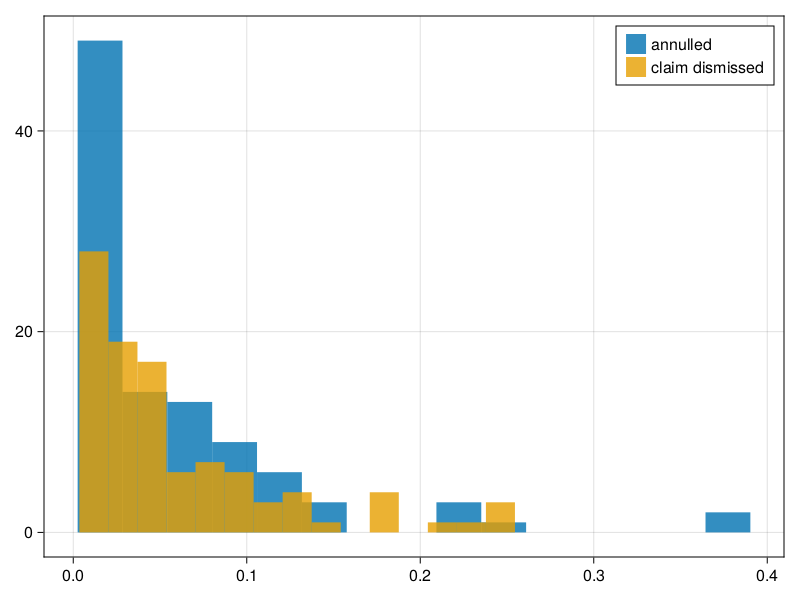

In [40]:
plot_densities(post.σy)